# Flower classifier 2 layers

_Author: Baccega Sandro_

In this notebook we will classify Oxford's `102 Category Flower Dataset` that can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

Another required asset to run this code is `Oxford-102_Flower_dataset_labels.txt` from JosephKJ that can be found [here](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1), this external file contains the flowers names.

---


## Imports and constants


In [16]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import torch
import shutil
import os
import tqdm
import matplotlib.pyplot as plt
import skimage.io as skio
from sklearn.metrics import confusion_matrix
import seaborn as sn
from tabulate import tabulate
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models, datasets
from torchvision.models import ResNet18_Weights

# --- CONSTANTS AND HYPERPARAMETERS ---

CHOOSEN_MODEL = 1
SEED = 151836
DATASET_SPLIT = 0.8             # Get 80% of dataset for training, the rest for testing/validation
TESTING_VALIDATION_SPLIT = 0.5  # Get 50% of testing dataset for validation, the rest for testing

BATCH_SIZE = 64
N_EPOCHS = 20
HIDDEN_LAYERS_OUTPUT_CHANNELS = [8, 16, 24, 32]
CROPPED_IMAGES_SIZE = 256
LEARNING_RATE = 0.001

# Assets location

RAW_IMAGE_LABELS_MAT_FILE = "assets/imagelabels.mat"
RAW_DATASET_LABELS_FILE = "assets/Oxford-102_Flower_dataset_labels.txt"
RAW_DATASET_IMAGES_FOLDER = "assets/jpg"
RAW_SEGMENTED_IMAGES_FOLDER = "assets/segmim"

# Data folder location

DATASET_IMAGES_FOLDER = "data/images"

# Setting seed
torch.manual_seed(SEED)

# Set device to use for computations
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else ("mps" if torch.backends.mps.is_available() else "cpu")
# )

print(f"-----\nPyTorch version: {torch.__version__}\nDevice: {device}\n-----")


-----
PyTorch version: 1.13.0.dev20220608
Device: cpu
-----


## Creating the sorted data folder


In [17]:
metadata = pd.DataFrame()
metadata['images'] = sorted(os.listdir(RAW_DATASET_IMAGES_FOLDER))
metadata["labels"] = loadmat(RAW_IMAGE_LABELS_MAT_FILE)["labels"][0] - 1 
metadata['labels'] = metadata['labels'].astype(str)

# print(metadata)

groups = metadata.groupby("labels")["images"].apply(list)

# Creating data folder (ImageFolder dataset)
# If data folder exists, do not create images folder
# if not os.path.isdir(DATASET_IMAGES_FOLDER):
#     print("Creating data folder")
#     os.mkdir(DATASET_IMAGES_FOLDER)

#     for category, images in groups.items():
#         os.mkdir("{}/{}".format(DATASET_IMAGES_FOLDER, category))
#         for image in images:
#             shutil.copyfile(
#                 "{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image),
#                 "{}/{}/{}".format(DATASET_IMAGES_FOLDER, category, image),
#             )

#     print("Done - data folder creation")
# else:
#     print("Skipping - data folder creation")


# Creating category to label reference
rawLabelReferenceData = np.loadtxt(RAW_DATASET_LABELS_FILE, dtype="str", delimiter="\n")
labelReferenceData = list(map(lambda str: str[2:-1], rawLabelReferenceData))

i = 0
labelReference = {}

for category, images in groups.items():
    labelReference[category] = labelReferenceData[i]
    i += 1

print("Done - label reference creation")
# print(labelReference)


Done - label reference creation


## Creating the datasets


Train dataset size: 6551
Validation dataset size: 819
Test dataset size: 819


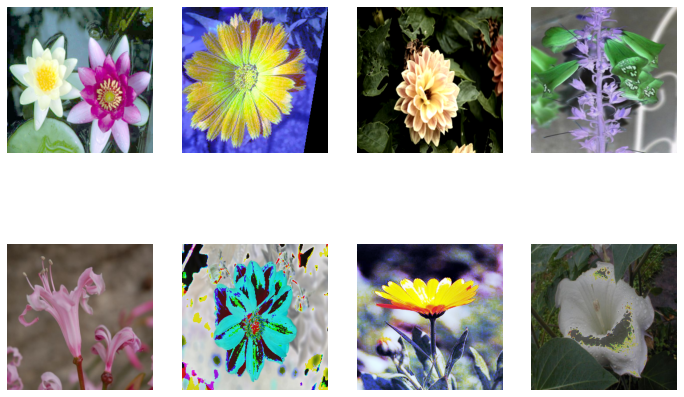

In [27]:
class FlowerDateset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.metadata.iloc[index, 0]
        image = skio.imread("{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image_path))
        label = torch.tensor(int(self.metadata.iloc[index, 1]))
        # label = F.one_hot(label, num_classes=102)
        # label = label.float()
        if self.transform:
            image = self.transform(image)

        return (image, label)

    def __len__(self):
        return len(self.metadata)


transform_train = transforms.Compose(
    [
        # transforms.ToPILImage(),
        # transforms.RandomRotation(45),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
        # transforms.RandomCrop(CROPPED_IMAGES_SIZE),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
transform_valid = transforms.Compose(
    [
        # transforms.ToPILImage(),
        # transforms.RandomRotation(45),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
        # transforms.RandomCrop(CROPPED_IMAGES_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


dataset_train = datasets.ImageFolder('data/images', transform=transform_train)
dataset_valid = datasets.ImageFolder('data/images', transform=transform_valid)
# dataset = FlowerDateset(metadata, transform=transform)

train_set_size = int(len(dataset_train) * DATASET_SPLIT)
validation_set_size = int((len(dataset_train) - train_set_size)  * TESTING_VALIDATION_SPLIT)
test_set_size = len(dataset_train) - validation_set_size - train_set_size

train_dataset, validation_test_dataset = data.random_split(
    dataset_train, [train_set_size, validation_set_size + test_set_size]
)
validation_dataset, test_dataset = data.random_split(
    validation_test_dataset, [validation_set_size, test_set_size]
)


train_dataset = torch.utils.data.Subset(train_dataset, indices=torch.arange(train_set_size))
validation_dataset = torch.utils.data.Subset(validation_dataset, indices=torch.arange(validation_set_size))
test_dataset = torch.utils.data.Subset(test_dataset, indices=torch.arange(test_set_size))

train_dataset.dataset.transform = transform_train
validation_dataset.dataset.transform = transform_valid
test_dataset.dataset.transform = transform_valid

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

print("Train dataset size: {}".format(len(train_dataset)))
print("Validation dataset size: {}".format(len(validation_dataset)))
print("Test dataset size: {}".format(len(test_dataset)))

n_rows = 2
n_cols = 4

for x, y in train_dataloader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i, j].imshow(x[(i * n_cols) + j].cpu().permute(1,2,0))
            ax[i, j].axis("off")
            #ax[i, j].set_title(labelReference[label])
    break


## Creating the model

Here we create our CNN model with 2 simple layers or use the ResNet18 model.

We use a kernel_size=(3,3), stride=(1,1) and padding=(1,1) in order to have a same convolution (manteins image size).

We use a MaxPool2d to reduce the size of the network by half efficiently.

We use a Linear to create the last fully connected layer.  

We use the Adam optimizer and the CrossEntropyLoss as our loss function.


In [19]:
class My2LayerCNN(nn.Module):
    def __init__(
        self,
        num_in_channels=3,
        num_out_channels=HIDDEN_LAYERS_OUTPUT_CHANNELS,
        img_width=CROPPED_IMAGES_SIZE,
        img_height=CROPPED_IMAGES_SIZE,
        num_classes=102,
    ):
        super(My2LayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_in_channels,
            out_channels=num_out_channels[0],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_out_channels[0],
            out_channels=num_out_channels[1],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear(
            in_features=int(img_width / 4) * int(img_height / 4) * num_out_channels[1],
            out_features=num_classes,
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.fc(x.reshape(x.shape[0], -1))
        return x
class My4LayerCNN(nn.Module):
    def __init__(
        self,
        num_in_channels=3,
        num_out_channels=HIDDEN_LAYERS_OUTPUT_CHANNELS,
        img_width=CROPPED_IMAGES_SIZE,
        img_height=CROPPED_IMAGES_SIZE,
        num_classes=102,
    ):
        super(My4LayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_in_channels,
            out_channels=num_out_channels[0],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_out_channels[0],
            out_channels=num_out_channels[1],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=num_out_channels[1],
            out_channels=num_out_channels[2],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv4 = nn.Conv2d(
            in_channels=num_out_channels[2],
            out_channels=num_out_channels[3],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear(
            in_features=int(img_width / 16) * int(img_height / 16) * num_out_channels[3],
            out_features=num_classes,
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.fc(x.view(x.shape[0], -1))
        return x


# Load saved model
if CHOOSEN_MODEL == 0:
    model = My2LayerCNN()
    model.load_state_dict(torch.load('model.pt'))
    model.eval()
# My 2 Layer CNN model
if CHOOSEN_MODEL == 1:
    model = My2LayerCNN()
# Resnet
if CHOOSEN_MODEL == 2:
    model = My4LayerCNN()
# Resnet pretrained
if CHOOSEN_MODEL == 3:
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 102)


model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()


## Train model


In [20]:
training_results_data = pd.DataFrame(
    {"Epoch": [], "Predictions": [], "Samples": [], "Accuracy": [], "Loss": []}
)

def check_accuracy(data_loader, model):
    n_corrects = 0
    n_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in data_loader:
            # Sending data to device
            x = x.to(device)
            y = y.to(device)

            # Forward propagation
            y_hat = model(x)

            # Calculate accuracy
            _, predictions = y_hat.max(1)
            n_corrects += (predictions == y).sum()
            n_samples += predictions.size(0)

        perc = (n_corrects.item() / n_samples) * 100
        return (n_corrects.item(), n_samples, perc)


if CHOOSEN_MODEL != 0: 
    model.train()
    # Tensorboard writer
    writer = SummaryWriter()
    for epoch in range(N_EPOCHS):
        running_loss = 0.0

        with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:

            for index, (x, y) in enumerate(tepoch):
        
                optimizer.zero_grad()
                # Send the data to the device
                x = x.to(device)
                y = y.to(device)

                # Forward propagation
                y_hat = model(x)
                loss = criterion(y_hat, y)
                running_loss += loss

                # Backward propagation
                # Calculate derivatives for every parameters
                loss.backward()
                # Do gradient descent
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())

            print(f"Epoch {epoch + 1}, loss: {running_loss}")
            n_corrects, n_samples, accuracy = check_accuracy(validation_dataloader, model)
            print(f"Accuracy: {n_corrects}/{n_samples} = {accuracy:.2f}%")
            # writer.add_figure("Confusion matrix", createConfusionMatrix(validation_dataloader, model), epoch)
            training_results_data.loc[len(training_results_data.index)] = [
                int(epoch + 1),
                int(n_corrects),
                int(n_samples),
                accuracy,
                running_loss.item(),
            ]
            writer.add_scalar("Loss/train", running_loss, epoch)
            writer.add_scalar('Accuracy/validation', accuracy, epoch)


    writer.flush()

    

    # Saving model
    torch.save(model.state_dict(), 'model.pt')

# Saving parameters
with open('model_parameters.txt', 'w') as file:
    file.write(f"CHOOSEN_MODEL = {CHOOSEN_MODEL}\n")
    file.write(f"SEED = {SEED}\n")
    file.write(f"DATASET_SPLIT = {DATASET_SPLIT}\n")
    file.write(f"TESTING_VALIDATION_SPLIT = {TESTING_VALIDATION_SPLIT}\n")
    file.write(f"BATCH_SIZE = {BATCH_SIZE}\n")
    file.write(f"N_EPOCHS = {N_EPOCHS}\n")
    file.write(f"HIDDEN_LAYERS_OUTPUT_CHANNELS = {HIDDEN_LAYERS_OUTPUT_CHANNELS}\n")
    file.write(f"CROPPED_IMAGES_SIZE = {CROPPED_IMAGES_SIZE}\n")
    file.write(f"LEARNING_RATE = {LEARNING_RATE}\n")

100%|██████████| 103/103 [04:47<00:00,  2.79s/batch, loss=4.15]


Epoch 1, loss: 455.0531005859375
Accuracy: 78/819 = 9.52%


100%|██████████| 103/103 [03:58<00:00,  2.32s/batch, loss=2.88]


Epoch 2, loss: 393.0860290527344
Accuracy: 115/819 = 14.04%


100%|██████████| 103/103 [04:04<00:00,  2.38s/batch, loss=3.38]


Epoch 3, loss: 357.9544372558594
Accuracy: 139/819 = 16.97%


100%|██████████| 103/103 [03:25<00:00,  1.99s/batch, loss=3.29]


Epoch 4, loss: 334.36834716796875
Accuracy: 159/819 = 19.41%


100%|██████████| 103/103 [03:52<00:00,  2.26s/batch, loss=2.76]


Epoch 5, loss: 306.9291687011719
Accuracy: 206/819 = 25.15%


100%|██████████| 103/103 [03:07<00:00,  1.82s/batch, loss=3.08]


Epoch 6, loss: 283.08416748046875
Accuracy: 197/819 = 24.05%


100%|██████████| 103/103 [03:21<00:00,  1.96s/batch, loss=2.15]


Epoch 7, loss: 247.5945281982422
Accuracy: 219/819 = 26.74%


100%|██████████| 103/103 [03:09<00:00,  1.84s/batch, loss=1.66]


Epoch 8, loss: 222.82623291015625
Accuracy: 228/819 = 27.84%


100%|██████████| 103/103 [03:48<00:00,  2.22s/batch, loss=0.81]


Epoch 9, loss: 199.87814331054688
Accuracy: 247/819 = 30.16%


100%|██████████| 103/103 [03:28<00:00,  2.02s/batch, loss=1.22]


Epoch 10, loss: 178.37623596191406
Accuracy: 251/819 = 30.65%


100%|██████████| 103/103 [04:20<00:00,  2.53s/batch, loss=1.21]


Epoch 11, loss: 164.04592895507812
Accuracy: 264/819 = 32.23%


100%|██████████| 103/103 [04:08<00:00,  2.41s/batch, loss=2.09]


Epoch 12, loss: 143.46127319335938
Accuracy: 274/819 = 33.46%


100%|██████████| 103/103 [03:57<00:00,  2.30s/batch, loss=0.915]


Epoch 13, loss: 135.598876953125
Accuracy: 250/819 = 30.53%


100%|██████████| 103/103 [03:51<00:00,  2.25s/batch, loss=1.35] 


Epoch 14, loss: 129.485595703125
Accuracy: 269/819 = 32.84%


100%|██████████| 103/103 [02:59<00:00,  1.75s/batch, loss=0.894]


Epoch 15, loss: 117.30966186523438
Accuracy: 265/819 = 32.36%


100%|██████████| 103/103 [04:31<00:00,  2.63s/batch, loss=1.12]


Epoch 16, loss: 116.75199127197266
Accuracy: 293/819 = 35.78%


100%|██████████| 103/103 [04:06<00:00,  2.39s/batch, loss=0.823]


Epoch 17, loss: 103.4679946899414
Accuracy: 284/819 = 34.68%


100%|██████████| 103/103 [05:00<00:00,  2.92s/batch, loss=0.706]


Epoch 18, loss: 100.62320709228516
Accuracy: 273/819 = 33.33%


100%|██████████| 103/103 [03:39<00:00,  2.13s/batch, loss=0.579]


Epoch 19, loss: 99.35804748535156
Accuracy: 294/819 = 35.90%


100%|██████████| 103/103 [02:34<00:00,  1.50s/batch, loss=1.08] 


Epoch 20, loss: 94.02859497070312
Accuracy: 291/819 = 35.53%


## Results

Training/Validation results
╒═════════╤═══════════════════════╤════════════╤══════════╕
│   Epoch │ Predictions/Samples   │ Accuracy   │     Loss │
╞═════════╪═══════════════════════╪════════════╪══════════╡
│       1 │ 78/819                │ 9.52%      │ 455.053  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       2 │ 115/819               │ 14.04%     │ 393.086  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       3 │ 139/819               │ 16.97%     │ 357.954  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       4 │ 159/819               │ 19.41%     │ 334.368  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       5 │ 206/819               │ 25.15%     │ 306.929  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       6 │ 197/819               │ 24.05%     │ 283.084  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       7 │ 219/819               │ 26.74%     │ 247.595  │
├─────────┼─

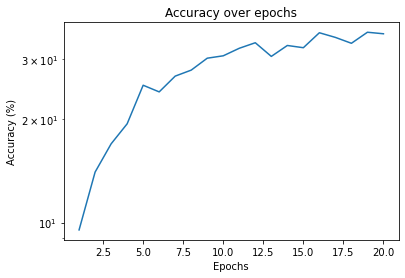

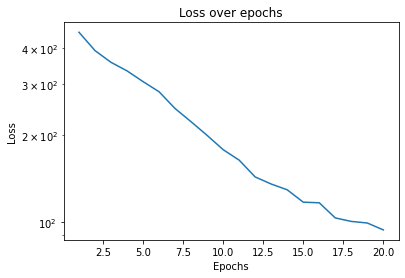

Testing results
Testing accuracy: 600/819 (73.26%)


In [28]:
def createConfusionMatrix(data_loader, model):
    confusion_matrix = torch.zeros((102, 102))
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    fig = plt.figure(figsize=(250,250))

    # confusion_matrix_np = confusion_matrix.numpy()
    # np.savetxt("confusion_matrix.csv", confusion_matrix_np, delimiter=",")
    
    class_names = list(labelReference.values())
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    df_cm.to_csv('confusion_matrix.csv')

    heatmap = sn.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=10)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=10)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
# def createConfusionMatrix(data_loader, model):
#     confusion_matrix = np.zeros((102, 102))
#     with torch.no_grad():
#         for i, (inputs, classes) in enumerate(data_loader):
#             inputs = inputs.to(device)
#             classes = classes.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             print(preds)
#             for t, p in zip(classes.view(-1), preds.view(-1)):
#                     confusion_matrix[t.long(), p.long()] += 1

#     # fig = plt.figure(figsize=(250,250))

#     class_names = list(labelReference.values())
#     df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#     df_cm.to_csv('confusion_matrix.csv')
#     # heatmap = sn.heatmap(df_cm, annot=True, fmt="d")

#     # heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=10)
#     # heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=10)
#     # plt.ylabel('True label')
#     # plt.xlabel('Predicted label')
#     # return fig

if CHOOSEN_MODEL != 0:
    print("Training/Validation results")
    formatted_training_results_data = pd.DataFrame(
        {"Epoch": [], "Predictions/Samples": [], "Accuracy": [], "Loss": []}
    )
    for index, row in training_results_data.iterrows():
        formatted_training_results_data.loc[len(formatted_training_results_data.index)] = [
                row[0],
                f"{int(row[1])}/{int(row[2])}",
                f"{row[3]:.2f}%",
                f"{row[4]}",
            ]

    print(tabulate(formatted_training_results_data, headers = 'keys', tablefmt = 'fancy_grid', showindex="never"))

    plt.plot(training_results_data["Epoch"], training_results_data["Accuracy"])
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.yscale('log')
    # plt.grid(True)
    plt.show()

    plt.plot(training_results_data["Epoch"], training_results_data["Loss"])
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    # plt.grid(True)
    plt.show()

print("Testing results")
n_corrects, n_samples, accuracy = check_accuracy(test_dataloader, model)
print(f"Testing accuracy: {n_corrects}/{n_samples} ({accuracy:.2f}%)")
writer.add_figure("Confusion matrix", createConfusionMatrix(test_dataloader, model))
writer.flush()
writer.close()
# createConfusionMatrix(test_dataloader, model)